In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib

from modules import network,mlp,contrastive_loss
from utils import yaml_config_hook,save_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes

adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


 Drop rare type cells including type 8, 10, 11, 13 and 14.

In [4]:
from torch.utils.data import DataLoader,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
4096
4096
2000
4096
4096


In [5]:
# initialize model
mlpp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlpp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [6]:
def chiasma(original, neighbor,prob=1, percentage=0.8):
    geneCount = original.shape[0]
    s = np.random.uniform(0, 1)
    if s < prob:
        chiasma_instance = int(geneCount * percentage / 2)
        chiasma_pair = np.random.randint(geneCount, size=(chiasma_instance, 2))
        # print(chiasma_pair.shape)
        original_copy=original.copy()
        neighbor_copy=neighbor.copy()
        original_copy[chiasma_pair[:,0]],neighbor_copy[chiasma_pair[:,1]]=neighbor[chiasma_pair[:,1]],original[chiasma_pair[:,0]]
        return original_copy,neighbor_copy


In [7]:
class StaticMemoryBank():

    def __init__(self,batch_size,x,y,dim):
        self.batch_size=batch_size
        self.dim=dim
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=8569, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(x)
        self.x_data=x
        self.y_data=y

    def generate_data(self,x_data,y_data):
        contrasts=np.zeros((self.batch_size,11,self.dim))
        # rare_list=[]
        for step,(x,y) in enumerate(zip(x_data,y_data)):
            if y in [8,10,11,13,14]:
                neighbor_index,distance=self.bank.knn_query(x,k=2)
                # print(neighbor_index)
                original_copy,neighbor_copy=chiasma(original=x,neighbor=x_ndarray[neighbor_index.squeeze()[1]])
                temp=np.tile(neighbor_copy, 10).reshape((10,args.num_genes))
                temp=np.row_stack((original_copy,temp))

                # rare_list.append(step)
                contrasts[step]=temp
            else:
                labels,distances=self.bank.knn_query(x,k=10)
                temp=x_ndarray[labels.tolist()]
                temp=np.row_stack((temp,x))
                contrasts[step]=temp

        # return contrasts,rare_list
        return contrasts

In [8]:
def train(instance_loss,cluster_loss,memory_bank,model):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        label=label.numpy().copy()
        
        contrast_samples=torch.tensor(memory_bank.generate_data(embedding_data,label),dtype=torch.float32)
        iter_times=10
        for index in range(1,11):
            x_i=contrast_samples[:,0].clone().to('cuda')
            # print(f'sample shape:\n{x_i.shape}')
            
            x_j=contrast_samples[:,index].to('cuda')
            # print(f'data shape:\n{x_j.shape}')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [9]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [10]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    return nmi, ari, f, acc

In [11]:
loss_device=torch.device('cuda')
instance_loss=contrastive_loss.InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=contrastive_loss.ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=StaticMemoryBank(batch_size=args.batch_size,x=x_ndarray,y=y_ndarray,dim=2000)

for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 1 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

Step [0/2]	 loss_instance: 8.994973182678223	 loss_cluster: 3.2981696128845215

Epoch [1/200]	 Loss: 12.283777475357056 

Step [0/2]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.3846 ARI = 0.2625 F = 0.5533 ACC = 0.0978

Step [0/2]	 loss_instance: 8.806783676147461	 loss_cluster: 3.297675848007202

Epoch [2/200]	 Loss: 12.079867124557495 

Step [0/2]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4667 ARI = 0.3167 F = 0.5872 ACC = 0.0281

Step [0/2]	 loss_instance: 8.501029014587402	 loss_cluster: 3.2944252490997314

Epoch [3/200]	 Loss: 11.80230393409729 

Step [0/2]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4717 ARI = 0.3204 F = 0.5863 ACC = 0.3213

Step [0/2]	 loss_instance: 8.369473457336426	 loss_cluster: 3.2817790508270264

Epoch [4/200]	 Loss: 11.67381443977356 

Step [0/2]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.3971 ARI = 0.2805 F = 0.5267 ACC = 0.2782

Step [0/2]	 loss_instance: 8.164767265319824	 loss_

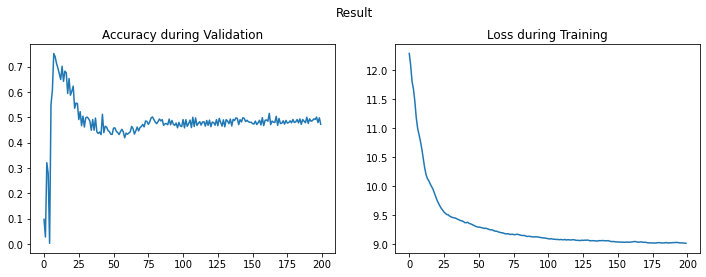

In [12]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

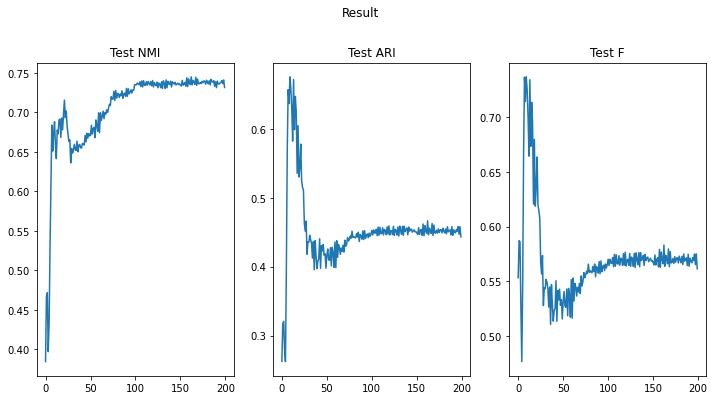

In [13]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

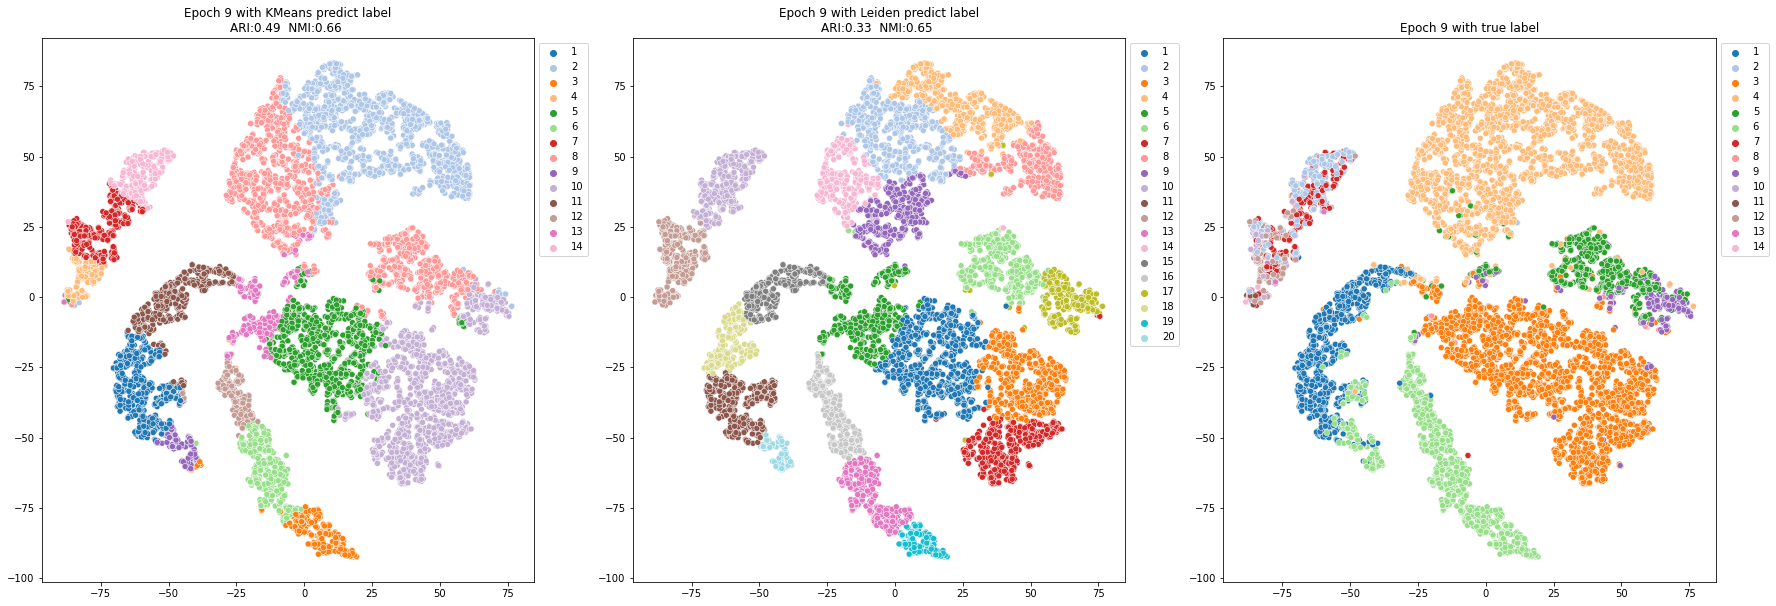

In [14]:
from evaluation import evaluation_tools
from sklearn.manifold import TSNE

mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim, args.classnum)
model = model.to('cuda')

checkpoint = torch.load('save\sc-static-bank-rare-swap\checkpoint_9.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=9)

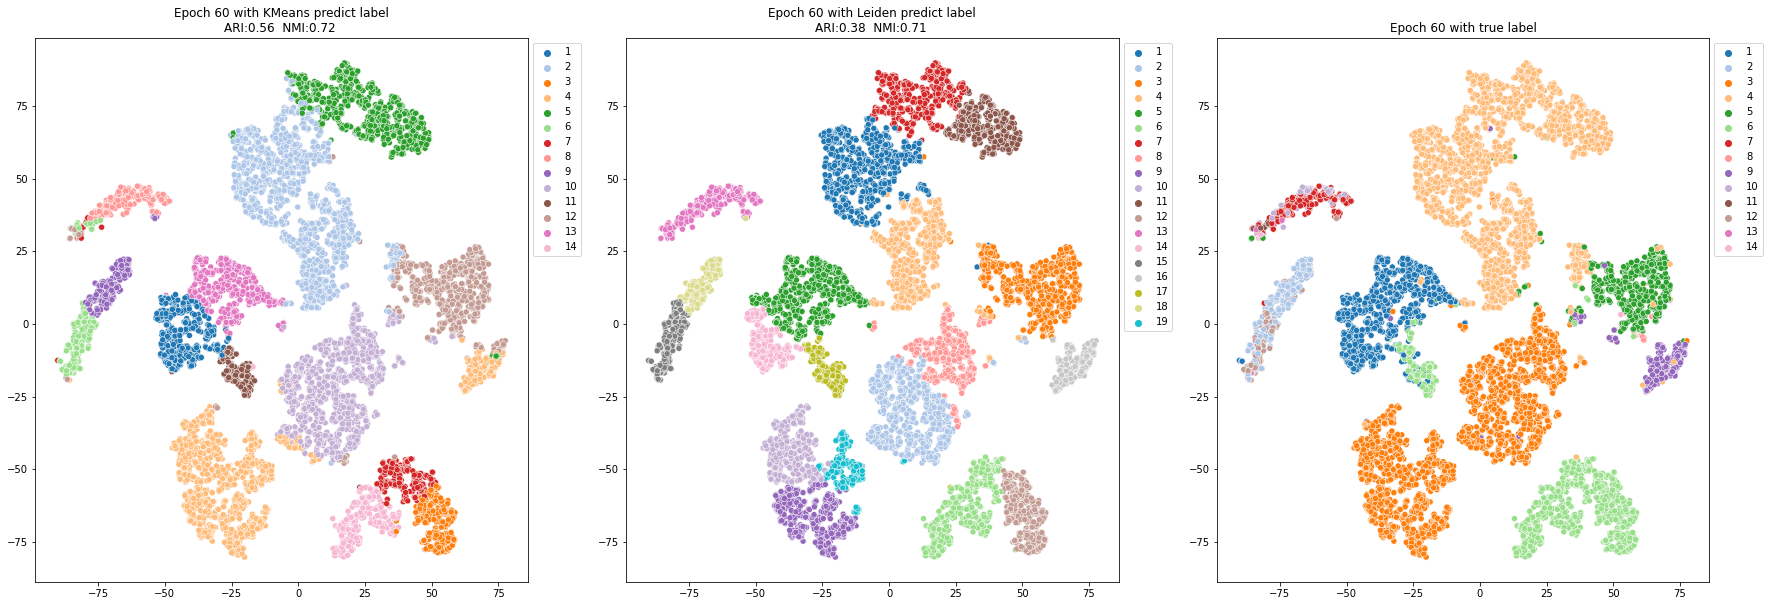

In [15]:
checkpoint = torch.load('save\sc-static-bank-rare-swap\checkpoint_60.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=60)

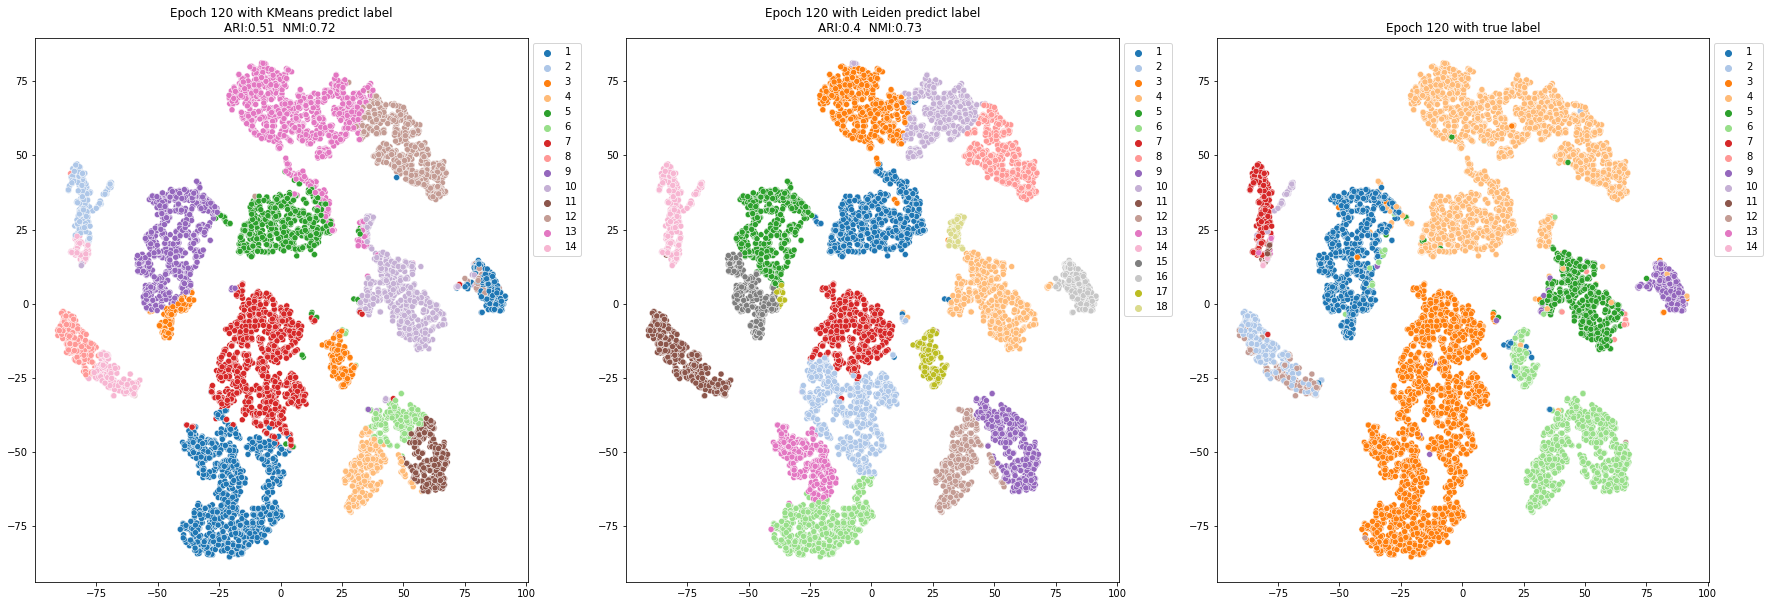

In [16]:
checkpoint = torch.load('save\sc-static-bank-rare-swap\checkpoint_120.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=120)

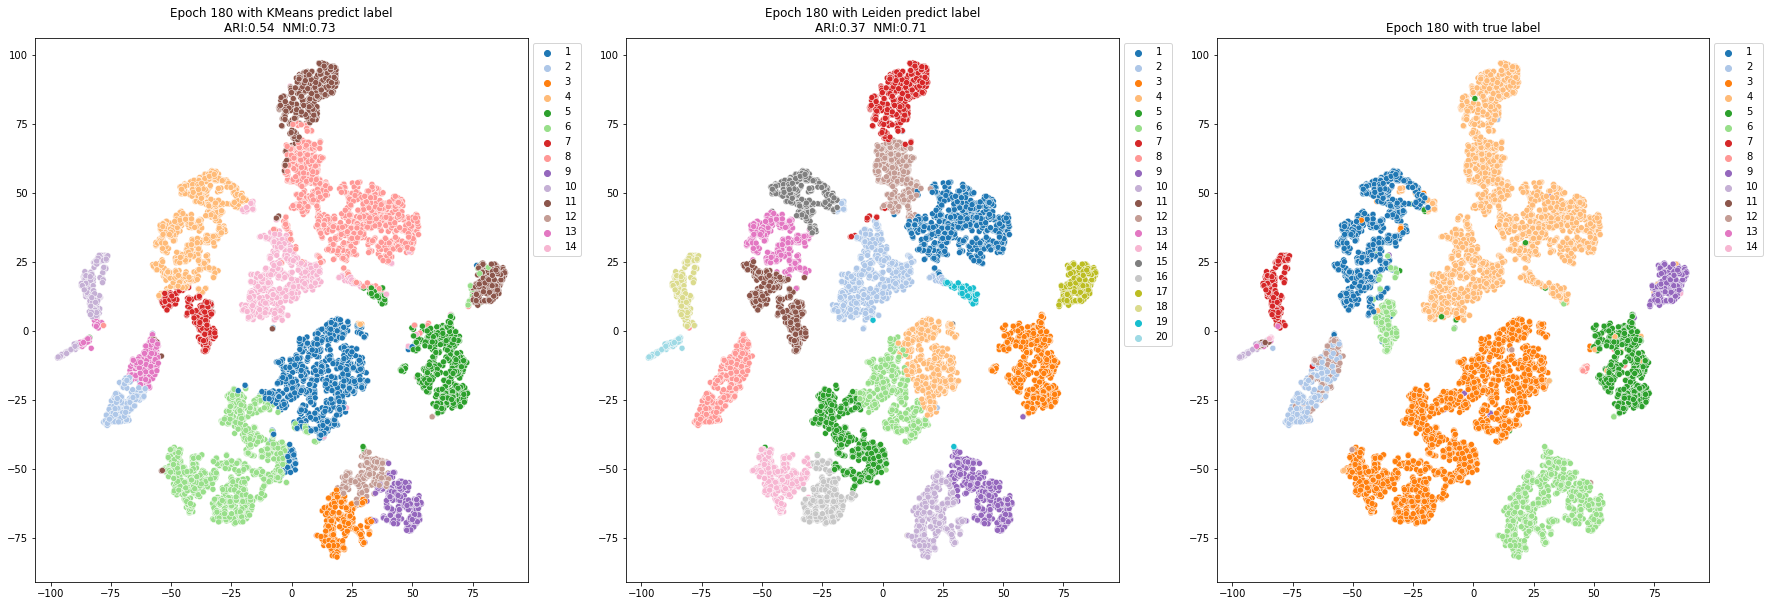

In [17]:
checkpoint = torch.load('save\sc-static-bank-rare-swap\checkpoint_180.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

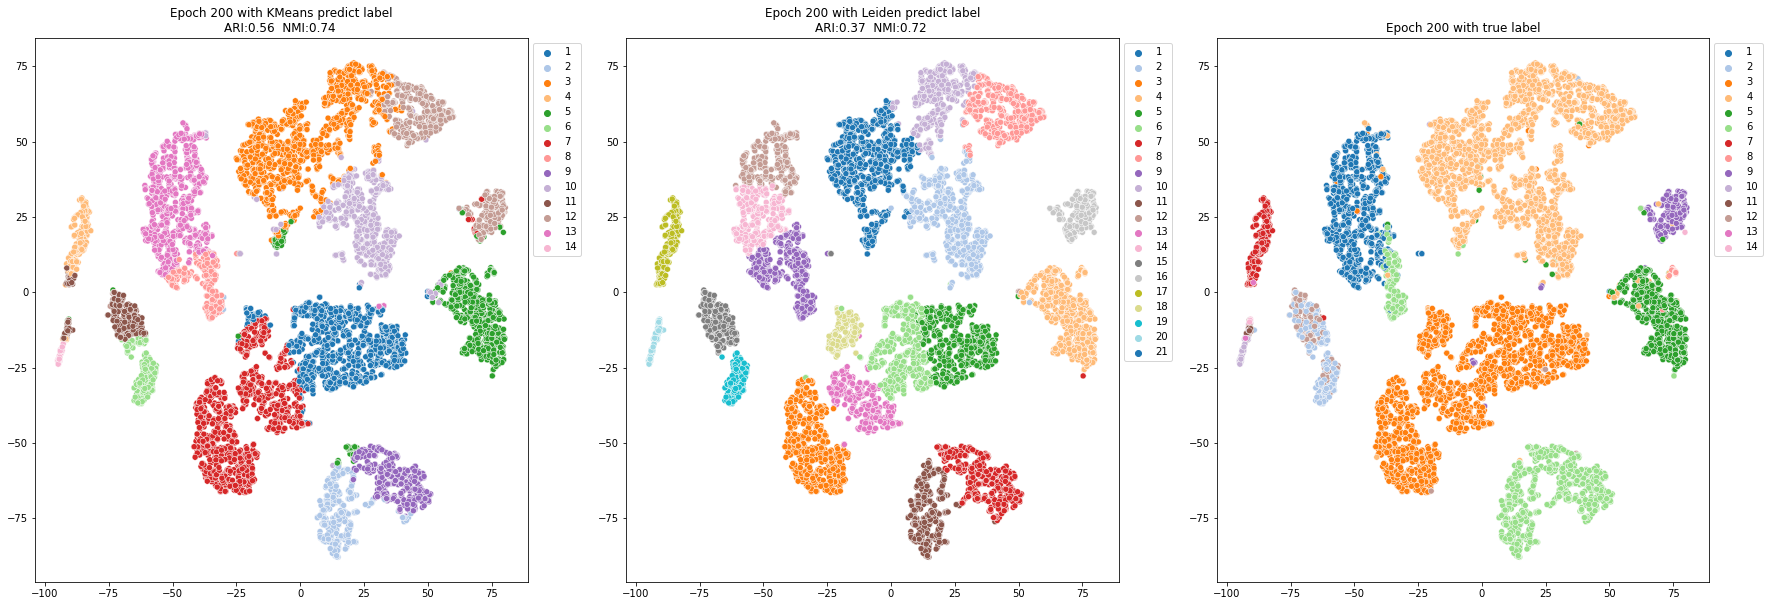

In [18]:
checkpoint = torch.load('save\sc-static-bank-rare-swap\checkpoint_200.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=200)